In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Parameters
L = 1.0  # Spatial domain
T = 0.5  # Time domain
c = 1.0  # Advection speed
N_ic = 100  # Initial condition points
N_bc = 100  # Boundary condition points
N_col = 1000  # Collocation points
epochs =  10000
learning_rate = 0.0005
loss_weights = [1.0, 10.0, 10.0]  # Weights for PDE, IC, BC losses

In [3]:
# Exact solution
def exact_solution(x, t):
    return np.exp(-100 * (((x - t) % L) - 0.2)**2)

In [4]:
# Neural Network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        scale = torch.tensor([L, T], dtype=torch.float32, device=x.device, requires_grad=False)
        inputs = 2.0 * inputs / scale - 1.0  # Normalize inputs
        return self.net(inputs)

In [5]:
# Loss function
def pinn_loss(model, x_col, t_col, x_ic, t_ic, u_ic, x_bc, t_bc,weights):
    x_col, t_col = x_col.requires_grad_(True), t_col.requires_grad_(True)
    u = model(x_col, t_col)
    u_t = torch.autograd.grad(u, t_col, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_col, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    pde_residual = u_t + c * u_x
    loss_pde = loss_pde = weights[0] * torch.mean(pde_residual**2)

    u_ic_pred = model(x_ic, t_ic)
    loss_ic = weights[1] * torch.mean((u_ic_pred - u_ic)**2)

    u_bc_left = model(x_bc, t_bc)
    u_bc_right = model(torch.ones_like(x_bc) * L, t_bc)
    loss_bc = weights[2] * torch.mean((u_bc_left - u_bc_right)**2)

    return loss_pde + loss_ic + loss_bc, loss_pde, loss_ic, loss_bc

In [6]:
# Data preparation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_ic = torch.linspace(0, L, N_ic).reshape(-1, 1).to(device)
t_ic = torch.zeros_like(x_ic).to(device)
u_ic = torch.tensor(exact_solution(x_ic.cpu().numpy(), t_ic.cpu().numpy()), dtype=torch.float32).to(device)
x_bc = torch.zeros(N_bc, 1).to(device)
t_bc = torch.linspace(0, T, N_bc).reshape(-1, 1).to(device)

In [7]:
# Training
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8)

In [8]:
# Store losses and metrics
loss_history = []
pde_loss_history = []
ic_loss_history = []
bc_loss_history = []
l2_error_history = []
pde_residual_history = []

start_time =  time.time()

In [9]:
for epoch in range(epochs):
    # Resample collocation points every 100 epochs
    if epoch % 100 == 0:
        x_col = torch.rand(N_col, 1).to(device) * L
        t_col = torch.rand(N_col, 1).to(device) * T

    optimizer.zero_grad()
    total_loss, loss_pde, loss_ic, loss_bc = pinn_loss(model, x_col, t_col, x_ic, t_ic, u_ic, x_bc, t_bc,loss_weights)
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    optimizer.step()
    scheduler.step()

    # Store losses
    loss_history.append(total_loss.item())
    pde_loss_history.append(loss_pde.item())
    ic_loss_history.append(loss_ic.item())
    bc_loss_history.append(loss_bc.item())

    # Evaluate metrics every 100 epochs
    if epoch % 100 == 0:
        # L2 error (no gradients needed)
        with torch.no_grad():
            x_test = torch.linspace(0, L, 100).reshape(-1, 1).to(device)
            t_test = torch.ones_like(x_test) * T
            u_pred = model(x_test, t_test)
            u_exact = torch.tensor(exact_solution(x_test.cpu().numpy(), t_test.cpu().numpy()), dtype=torch.float32).to(device)
            l2_error = torch.sqrt(torch.mean((u_pred - u_exact)**2))
            l2_error_history.append(l2_error.item())

        # PDE residual (requires gradients)
        x_res = torch.rand(1000, 1).to(device).requires_grad_(True) * L
        t_res = torch.rand(1000, 1).to(device).requires_grad_(True) * T
        u_res = model(x_res, t_res)
        u_t_res = torch.autograd.grad(u_res, t_res, grad_outputs=torch.ones_like(u_res).to(device), create_graph=True)[0]
        u_x_res = torch.autograd.grad(u_res, x_res, grad_outputs=torch.ones_like(u_res).to(device), create_graph=True)[0]
        pde_residual = torch.sqrt(torch.mean((u_t_res + c * u_x_res)**2))
        pde_residual_history.append(pde_residual.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item():.4e}, L2 Error: {l2_error.item():.4e}, PDE Residual: {pde_residual.item():.4e}")

end_time = time.time()
training_time = end_time - start_time

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Total Loss: 1.9266e+01, L2 Error: 3.3221e-01, PDE Residual: 1.2303e+00
Epoch 1000, Total Loss: 6.5871e-03, L2 Error: 3.0726e-02, PDE Residual: 3.9547e-02
Epoch 2000, Total Loss: 4.2525e-03, L2 Error: 1.9694e-02, PDE Residual: 3.1034e-02
Epoch 3000, Total Loss: 3.7288e-04, L2 Error: 4.0730e-03, PDE Residual: 1.0739e-02
Epoch 4000, Total Loss: 2.1603e-04, L2 Error: 3.2931e-03, PDE Residual: 7.7231e-03
Epoch 5000, Total Loss: 1.7053e-04, L2 Error: 3.2284e-03, PDE Residual: 5.5691e-03
Epoch 6000, Total Loss: 1.2719e-04, L2 Error: 2.7912e-03, PDE Residual: 4.4960e-03
Epoch 7000, Total Loss: 1.1028e-04, L2 Error: 2.5756e-03, PDE Residual: 3.8395e-03
Epoch 8000, Total Loss: 9.8379e-05, L2 Error: 2.3939e-03, PDE Residual: 3.2546e-03
Epoch 9000, Total Loss: 9.6511e-05, L2 Error: 2.2056e-03, PDE Residual: 3.0028e-03


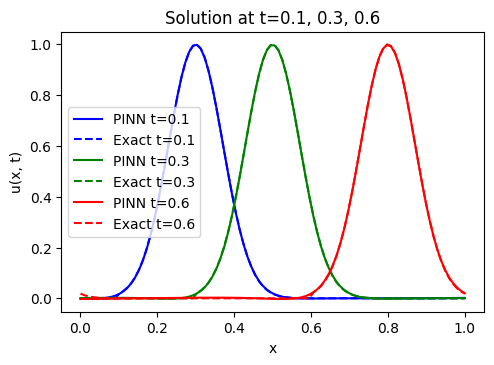

In [10]:
# Final evaluation at multiple time points
time_points = [0.1, 0.3, 0.6]
u_pred_list = []
u_exact_list = []
l2_errors = []
with torch.no_grad():
    x_test = torch.linspace(0, L, 100).reshape(-1, 1).to(device)
    for t_val in time_points:
        t_test = torch.ones_like(x_test) * t_val
        u_pred = model(x_test, t_test).cpu().numpy()
        u_exact = exact_solution(x_test.cpu().numpy(), t_test.cpu().numpy())
        u_pred_list.append(u_pred)
        u_exact_list.append(u_exact)
        l2_error = np.sqrt(np.mean((u_pred - u_exact)**2))
        l2_errors.append(l2_error)

# Plotting results
plt.figure(figsize=(12, 8))

# Solution comparison at multiple time points
plt.subplot(2, 2, 1)
colors = ['blue', 'green', 'red']
for i, t_val in enumerate(time_points):
    plt.plot(x_test.cpu().numpy(), u_pred_list[i], color=colors[i], label=f'PINN t={t_val}')
    plt.plot(x_test.cpu().numpy(), u_exact_list[i], '--', color=colors[i], label=f'Exact t={t_val}')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('Solution at t=0.1, 0.3, 0.6')
plt.legend()


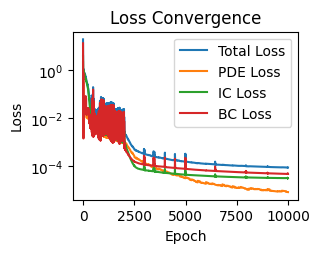

In [11]:
# Loss history
plt.subplot(2, 2, 2)
plt.semilogy(loss_history, label='Total Loss')
plt.semilogy(pde_loss_history, label='PDE Loss')
plt.semilogy(ic_loss_history, label='IC Loss')
plt.semilogy(bc_loss_history, label='BC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()


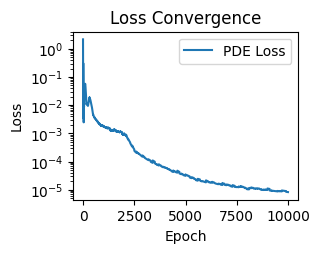

In [12]:
# Loss history
plt.subplot(2, 2, 2)
# plt.semilogy(loss_history, label='Total Loss')
plt.semilogy(pde_loss_history, label='PDE Loss')
# plt.semilogy(ic_loss_history, label='IC Loss')
# plt.semilogy(bc_loss_history, label='BC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()


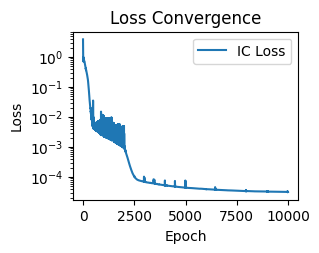

In [13]:
# Loss history
plt.subplot(2, 2, 2)
# plt.semilogy(loss_history, label='Total Loss')
# plt.semilogy(pde_loss_history, label='PDE Loss')
plt.semilogy(ic_loss_history, label='IC Loss')
# plt.semilogy(bc_loss_history, label='BC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()


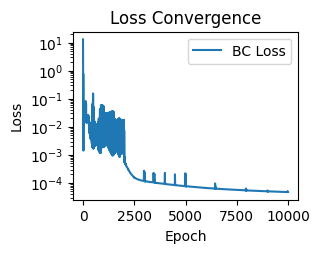

In [14]:
# Loss history
plt.subplot(2, 2, 2)
# plt.semilogy(loss_history, label='Total Loss')
# plt.semilogy(pde_loss_history, label='PDE Loss')
# plt.semilogy(ic_loss_history, label='IC Loss')
plt.semilogy(bc_loss_history, label='BC Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()


Text(0.5, 1.0, 'L2 Error vs. Epoch')

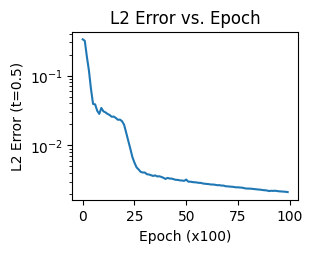

In [15]:

# L2 error history (at t=0.5)
plt.subplot(2, 2, 3)
plt.semilogy(l2_error_history)
plt.xlabel('Epoch (x100)')
plt.ylabel('L2 Error (t=0.5)')
plt.title('L2 Error vs. Epoch')



Text(0.5, 1.0, 'PDE Residual vs. Epoch')

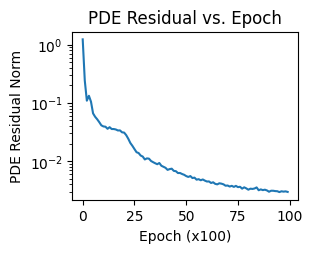

In [16]:
# PDE residual history
plt.subplot(2, 2, 4)
plt.semilogy(pde_residual_history)
plt.xlabel('Epoch (x100)')
plt.ylabel('PDE Residual Norm')
plt.title('PDE Residual vs. Epoch')



In [17]:
plt.tight_layout()
plt.savefig('pinn_results.png')
plt.show()



<Figure size 640x480 with 0 Axes>

In [18]:
print("Final L2 Errors:")
for t_val, l2_error in zip(time_points, l2_errors):
    print(f"t={t_val}: {l2_error:.4e}")
print(f"Training Time: {training_time:.2f} seconds")

Final L2 Errors:
t=0.1: 1.4741e-03
t=0.3: 1.8415e-03
t=0.6: 3.7732e-03
Training Time: 93.42 seconds


   Epoch  Total Loss  PDE Loss   IC Loss    BC Loss
0      1   19.266161  2.162675  3.902964  13.200521
1      2   14.073451  1.523774  3.246873   9.302804
2      3    9.787151  1.001638  2.670286   6.115228
3      4    6.379397  0.591594  2.169829   3.617973
4      5    3.821176  0.289856  1.742050   1.789271
5      6    2.086407  0.094882  1.384312   0.607214
6      7    1.153823  0.007401  1.094896   0.051526
7      8    1.006043  0.032643  0.873685   0.099715
8      9    1.313277  0.137475  0.763554   0.412248
9     10    1.633304  0.240878  0.723282   0.669144
Loss breakdown saved to loss_breakdown.csv


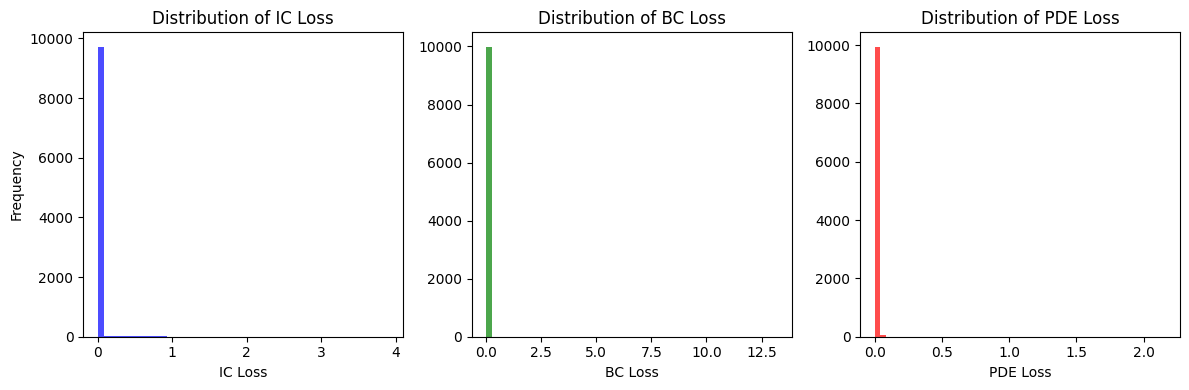

In [19]:
import pandas as pd

# Create a DataFrame for the losses
loss_df = pd.DataFrame({
    "Epoch": range(1, epochs + 1),
    "Total Loss": loss_history,
    "PDE Loss": pde_loss_history,
    "IC Loss": ic_loss_history,
    "BC Loss": bc_loss_history
})

# Show first 10 rows as a preview
print(loss_df.head(10))

# Save losses to CSV
loss_df.to_csv("loss_breakdown.csv", index=False)
print("Loss breakdown saved to loss_breakdown.csv")

# Plot histograms of the losses
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(ic_loss_history, bins=50, color='blue', alpha=0.7)
plt.xlabel("IC Loss")
plt.ylabel("Frequency")
plt.title("Distribution of IC Loss")

plt.subplot(1, 3, 2)
plt.hist(bc_loss_history, bins=50, color='green', alpha=0.7)
plt.xlabel("BC Loss")
plt.title("Distribution of BC Loss")

plt.subplot(1, 3, 3)
plt.hist(pde_loss_history, bins=50, color='red', alpha=0.7)
plt.xlabel("PDE Loss")
plt.title("Distribution of PDE Loss")

plt.tight_layout()
plt.savefig("loss_histograms.png")
plt.show()
